<a href="https://colab.research.google.com/github/03axdov/Notebooks/blob/main/FlowersDAugmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
import tensorflow_datasets as tfds

from tensorflow.keras import layers

In [2]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    "tf_flowers",
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    as_supervised=True,
    with_info=True
)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to ~/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [3]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


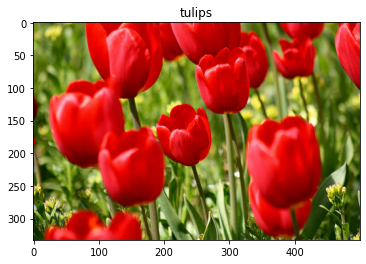

In [4]:
get_label_name = metadata.features["label"].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [5]:
IMG_SIZE = 180

resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMG_SIZE, IMG_SIZE),
    layers.Rescaling(1/255.0)
])

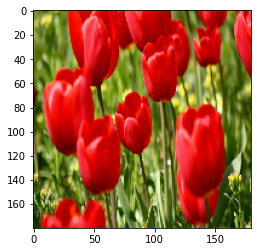

In [6]:
result = resize_and_rescale(image)
_ = plt.imshow(result)

In [7]:
print(f"Min pixel: {result.numpy().min()}, max pixel: {result.numpy().max()}")

Min pixel: 0.0, max pixel: 1.0


In [8]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [9]:
image = tf.cast(tf.expand_dims(image, axis=0), tf.float32)

In [10]:
print(image.shape)

(1, 333, 500, 3)


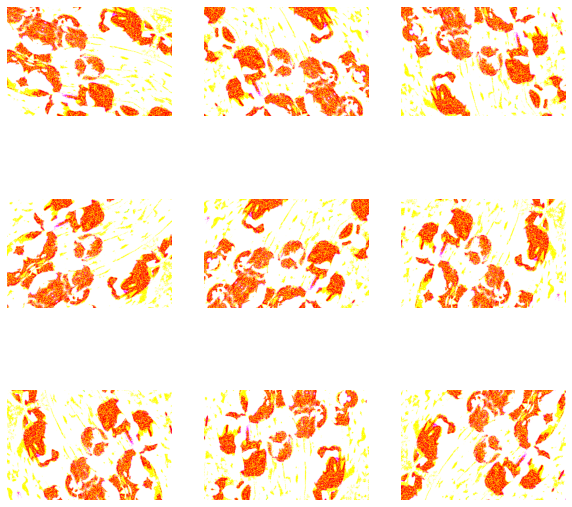

In [11]:
plt.figure(figsize=(10,10))
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.imshow(data_augmentation(image[0]))
  plt.axis("off")

In [12]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 32

def prepare(ds, shuffle=False, augment=False):
  ds = ds.cache().map(lambda x, y: (resize_and_rescale(x), y), num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds.shuffle(1000)

  ds = ds.batch(BATCH_SIZE)

  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)

  return ds.prefetch(buffer_size=AUTOTUNE)

In [13]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

In [14]:
model = tf.keras.Sequential([
    layers.Conv2D(16, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(32, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Flatten(),

    layers.Dense(128, activation="relu"),
    layers.Dense(num_classes)
])

In [15]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

In [ ]:
EPOCHS = 5

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
)

In [ ]:
history_dic = history.history
print(history_dic.keys())

In [ ]:
accuracy = history_dic["accuracy"]
val_accuracy = history_dic["val_accuracy"]

loss = history_dic["loss"]
val_loss = history_dic["val_loss"]

plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.plot(accuracy, label="Accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.ylabel("Accuracy")
plt.legend(loc="upper left")

plt.subplot(2,1,2)
plt.plot(loss, label="Loss")
plt.plot(val_loss, label="Validation loss")
plt.ylabel("Loss")
plt.legend(loc="upper left")

In [ ]:
loss, acc = model.evaluate(test_ds)
print(f"Loss: {loss}, Accuracy: {acc}")

In [ ]:
def random_invert_img(x, p=0.5):
  if tf.random.uniform([]) < p:
    x = (255 - x)
  else:
    x

  return x

In [ ]:
def random_invert(factor=0.5):
  return layers.Lambda(lambda x: random_invert_img(x, factor))

In [ ]:
random_invert = random_invert()

In [ ]:
plt.figure(figsize=(10,10))
for i in range(9):
  augmented_image = random_invert(image)
  plt.subplot(3,3,i+1)
  plt.imshow(augmented_image[0].numpy().astype("uint8"))
  plt.axis("off")

In [ ]:
class RandomInvert(layers.Layer):
  def __init__(self, factor=0.5, **kwargs):
    super().__init__(**kwargs)
    self.factor = factor

  def call(self, x):
    return random_invert_img(x)

In [ ]:
_ = plt.imshow(RandomInvert()(image)[0])